In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
pip install mlxtend

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Dependency for mlxtend
import six
import sys
sys.modules['sklearn.externals.six'] = six

from mlxtend.regressor import StackingCVRegressor

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn import preprocessing

# to build machine learning models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# to evaluate the models
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

sys.modules['sklearn.externals.six'] = six

In [5]:
nonevents_df = pd.read_csv("nonevent_data.csv",header=0,names=['device_id','gender','age','group_train','phone_brand','device_model'])
nonevents_df.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,3126957642374570000,M,27,M25-32,meitu,2
1,6005031767544890000,F,30,F25-32,meitu,2
2,-1463646610464190000,F,24,F0-24,meitu,2
3,4284600327477860000,F,22,F0-24,meitu,2
4,7858160688153530000,M,21,M0-24,meitu,2


In [6]:
events_df = pd.read_csv("event.csv",header=0,names=['device_id','gender','age','group_train','event_id','eventdate','longitude','latitude'])
#device_id	gender	age	group_train	event_id	eventdate	longitude	latitude
#events_df = pd.read_csv("event_data.csv")
events_df.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude
0,2.291390e+18,M,46,M32+,1757890,04-05-2016 20:57,113,35.08
1,-6.633250e+18,M,48,M32+,1757907,05-05-2016 20:57,114,22.61
2,-4.989750e+18,M,37,M32+,1757917,05-05-2016 21:45,114,30.56
3,-4.989750e+18,M,37,M32+,1757918,05-05-2016 21:46,114,30.56
4,-5.687500e+16,M,39,M32+,1757935,05-05-2016 20:56,116,25.06


In [7]:
events_df.device_id = events_df.device_id.astype("int64")

In [8]:
events_df.shape

(325105, 8)

In [9]:
nonevents_df.shape

(74838, 6)

In [10]:
#Since app_data file size is huge and we have budget restrictions on AWS to use high memeory EC2 instances.
#We are keeping only 1M records for our EDA and Plotting, Once model implementation is done we can use rest of data to train the model
app_df = pd.read_csv('app_data .csv',
                     header=0,names=['event_id','app_id','is_installed','is_active','label_id','cat'],
                     nrows=1000000, quoting=3, error_bad_lines=False, low_memory=False)

In [11]:
app_df.head()

,event_id,app_id,is_installed,is_active,label_id,cat
0,83635,-1.000040e+18,1,0,704,Property Industry 2.0
1,83635,-1.000040e+18,1,0,810,Casual puzzle categories
2,386692,-1.000040e+18,1,0,704,Property Industry 2.0
3,386692,-1.000040e+18,1,0,810,Casual puzzle categories
4,32074,-1.000040e+18,1,0,704,Property Industry 2.0


In [12]:
app_df.to_csv("app_data_1M.csv", index=False)

In [13]:
nonevents_df.isnull().sum()

device_id       0
gender          0
age             0
group_train     0
phone_brand     0
device_model    0
dtype: int64

In [14]:
events_df.isnull().sum()

device_id      0
gender         0
age            0
group_train    0
event_id       0
eventdate      0
longitude      0
latitude       0
dtype: int64

In [15]:
app_df.isnull().sum()

event_id        0
app_id          0
is_installed    0
is_active       0
label_id        0
cat             0
dtype: int64

# EDA Questions


# 1. Plot appropriate graphs representing the distribution of age and gender in the data set [univariate].

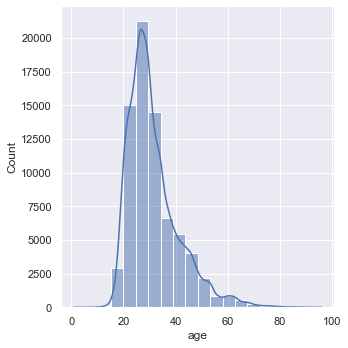

In [16]:
sns.displot(nonevents_df['age'], kde=True, bins=20)
plt.show()

# 2. Boxplot analysis for gender and age [bivariate].

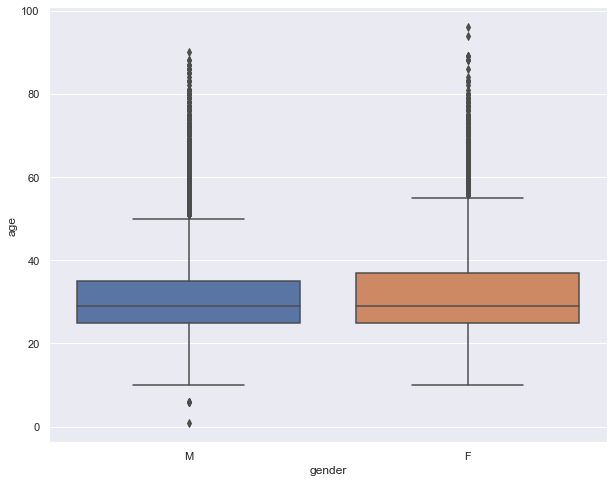

In [17]:
plt.figure(figsize=(10,8))
sns.boxplot(data=nonevents_df,x=nonevents_df['gender'],y=nonevents_df['age']) 
plt.show()

# 3. Plot the percentage of the device_ids with and without event data

In [18]:
#duplicate for event data df
percent_eventdf=events_df.drop_duplicates(subset=['device_id'])

print(percent_eventdf.shape)

print(percent_eventdf.head(2))

percent_eventdf['app_event']='Y'

print(percent_eventdf.head(2))

(19484, 8)
             device_id gender  age group_train  event_id         eventdate  \
0  2291390000000000000      M   46        M32+   1757890  04-05-2016 20:57   
1 -6633250000000000000      M   48        M32+   1757907  05-05-2016 20:57   

   longitude  latitude  
0        113     35.08  
1        114     22.61  
             device_id gender  age group_train  event_id         eventdate  \
0  2291390000000000000      M   46        M32+   1757890  04-05-2016 20:57   
1 -6633250000000000000      M   48        M32+   1757907  05-05-2016 20:57   

   longitude  latitude app_event  
0        113     35.08         Y  
1        114     22.61         Y  


<ipython-input-18-f05d2f11595f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percent_eventdf['app_event']='Y'


In [19]:
# duplicate for noneven df

percent_noneventdf=nonevents_df.drop_duplicates(subset=['device_id'])

percent_noneventdf['app_event']='N'

print(percent_noneventdf.head(2))

             device_id gender  age group_train phone_brand device_model  \
0  3126957642374570000      M   27      M25-32       meitu            2   
1  6005031767544890000      F   30      F25-32       meitu            2   

  app_event  
0         N  
1         N  


<ipython-input-19-c61c92501381>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percent_noneventdf['app_event']='N'


In [20]:
percent_eventdf=percent_eventdf[['device_id','app_event']]
percent_noneventdf=percent_noneventdf[['device_id','app_event']]
totPereventdf=pd.concat([percent_eventdf,percent_noneventdf],axis=0)

In [21]:
totPereventdf.head()

,device_id,app_event
0,2291390000000000000,Y
1,-6633250000000000000,Y
2,-4989750000000000000,Y
4,-56875000000000000,Y
5,-4651630000000000000,Y


In [22]:
percentage_event_noneventdf=totPereventdf['app_event'].value_counts(normalize=True).mul(100).rename('Per').reset_index()

In [23]:
percentage_event_noneventdf

,index,Per
0,N,79.300307
1,Y,20.699693


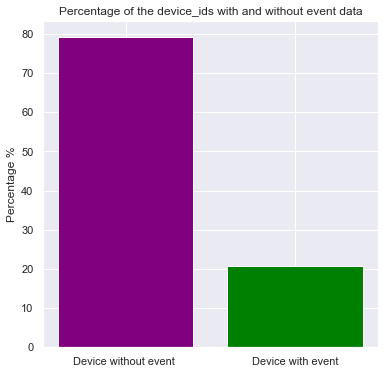

In [24]:
plt.figure(figsize=(6,6))
plt.title('Percentage of the device_ids with and without event data')
colors_list = ['Purple', 'green']

data = pd.DataFrame({'Format':['Device without event ','Device with event'],
                     
                     'per':percentage_event_noneventdf['Per']
                    })

plt.bar(data.Format,data.per, color = colors_list)

#plt.bar(percentage_event_noneventdf['index'],percentage_event_noneventdf['Per'])
#plt.xlabel('Device with/Without event')
#label=['without event','withevent']
plt.ylabel('Percentage %')
plt.show()

# 4. Plot a graph representing the distribution of events over different days of a week.

In [25]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325105 entries, 0 to 325104
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   device_id    325105 non-null  int64  
 1   gender       325105 non-null  object 
 2   age          325105 non-null  int64  
 3   group_train  325105 non-null  object 
 4   event_id     325105 non-null  int64  
 5   eventdate    325105 non-null  object 
 6   longitude    325105 non-null  int64  
 7   latitude     325105 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 19.8+ MB


In [26]:
events_df['eventdate']=pd.to_datetime(events_df['eventdate'])
events_df.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude
0,2291390000000000000,M,46,M32+,1757890,2016-04-05 20:57:00,113,35.08
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06


In [27]:
events_df['dayofweek_num'] = pd.to_datetime(events_df['eventdate']).dt.weekday
events_df['day'] = pd.to_datetime(events_df['eventdate']).dt.day
events_df['hour'] = pd.to_datetime(events_df['eventdate']).dt.hour
events_df['week'] = pd.to_datetime(events_df['eventdate']).dt.week

<ipython-input-27-0d7627f8bfe9>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  events_df['week'] = pd.to_datetime(events_df['eventdate']).dt.week


In [28]:
events_df['DayofWeek']=events_df['eventdate'].dt.day_name()
events_df.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek
0,2291390000000000000,M,46,M32+,1757890,2016-04-05 20:57:00,113,35.08,1,5,20,14,Tuesday
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61,3,5,20,18,Thursday
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56,3,5,21,18,Thursday
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56,3,5,21,18,Thursday
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06,3,5,20,18,Thursday


In [29]:
percentageDayofWeek_eventdf=events_df['DayofWeek'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

In [30]:
percentageDayofWeek_eventdf.head()

,index,Percentage
0,Tuesday,41.947063
1,Saturday,14.781994
2,Thursday,14.779840
3,Sunday,14.537150
4,Friday,13.953953


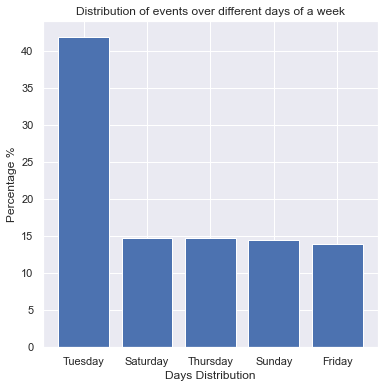

In [31]:
plt.figure(figsize=(6,6))
plt.title('Distribution of events over different days of a week')

plt.bar(percentageDayofWeek_eventdf['index'] ,percentageDayofWeek_eventdf['Percentage'],)
plt.xlabel('Days Distribution')
plt.ylabel('Percentage %')


plt.show()

#### 5. Plot a graph representing the distribution of events per hour [for one-week data]

In [32]:
eventdf_week = events_df[(events_df['eventdate']>'2016-04-30') & (events_df['eventdate']<='2016-05-07')]

In [33]:
print (eventdf_week.shape)
print (events_df.shape)

(48160, 13)
(325105, 13)


In [34]:
eventdf_week.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61,3,5,20,18,Thursday
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56,3,5,21,18,Thursday
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56,3,5,21,18,Thursday
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06,3,5,20,18,Thursday
5,-4651630000000000000,F,26,F25-32,1757936,2016-05-05 21:05:00,0,0.00,3,5,21,18,Thursday


In [35]:
eventdf_week['hourly']=eventdf_week['eventdate'].dt.hour

<ipython-input-35-552655236c33>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventdf_week['hourly']=eventdf_week['eventdate'].dt.hour


In [36]:
eventdf_week.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek,hourly
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61,3,5,20,18,Thursday,20
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56,3,5,21,18,Thursday,21
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56,3,5,21,18,Thursday,21
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06,3,5,20,18,Thursday,20
5,-4651630000000000000,F,26,F25-32,1757936,2016-05-05 21:05:00,0,0.00,3,5,21,18,Thursday,21


In [37]:
eventdf_weekPercentage=eventdf_week['hourly'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
eventdf_weekPercentage.head()

,index,Percentage
0,21,5.849252
1,10,5.780731
2,22,5.299003
3,20,5.251246
4,12,5.137043


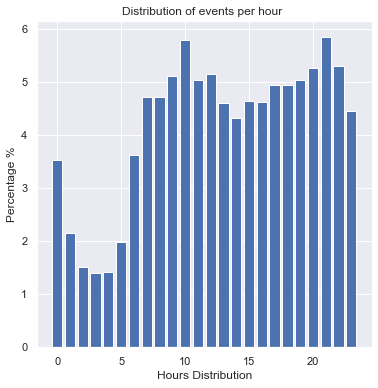

In [38]:
plt.figure(figsize=(6,6))
plt.title('Distribution of events per hour ')

plt.bar(eventdf_weekPercentage['index'],eventdf_weekPercentage['Percentage'])
plt.xlabel('Hours Distribution')
plt.ylabel('Percentage %')
plt.show()

# 6. The difference in the distribution of events per hour for Male and Female consumers. [Show the difference using an appropriate chart for one-week data.]

In [39]:
eventDataMaleFemale_hourlydf= (eventdf_week.groupby(['hourly']).gender.value_counts()).unstack()
eventDataMaleFemale_hourlydf.head()

gender,F,M
hourly,,
0,401,1298
1,276,760
2,194,530
3,178,500
4,225,457


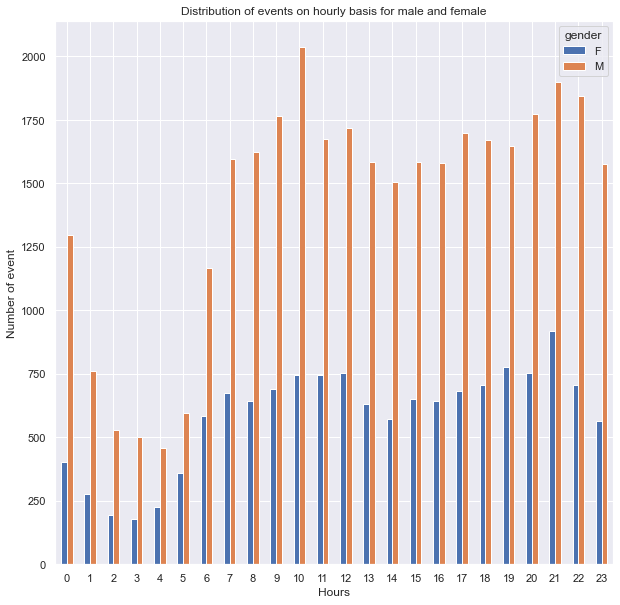

In [40]:
eventDataMaleFemale_hourlydf.plot(kind='bar',figsize=(10,10),rot=0)
plt.title('Distribution of events on hourly basis for male and female')
plt.xlabel('Hours')
plt.ylabel('Number of event')
plt.show()

# 7. Is there any difference in the distribution of Events for different Age Groups over different days of the week? [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

In [41]:
eventdf_week['Agebins']=pd.cut(eventdf_week['age'],bins=[0,24,32,45,100],labels=['0-24','25-32','33-45','46+'])
eventdf_week.head()

<ipython-input-41-3ed5e1249164>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventdf_week['Agebins']=pd.cut(eventdf_week['age'],bins=[0,24,32,45,100],labels=['0-24','25-32','33-45','46+'])


,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek,hourly,Agebins
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61,3,5,20,18,Thursday,20,46+
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56,3,5,21,18,Thursday,21,33-45
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56,3,5,21,18,Thursday,21,33-45
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06,3,5,20,18,Thursday,20,33-45
5,-4651630000000000000,F,26,F25-32,1757936,2016-05-05 21:05:00,0,0.00,3,5,21,18,Thursday,21,25-32


In [42]:
eventDataageBins_DOWdf= (eventdf_week.groupby(['Agebins']).DayofWeek.value_counts()).unstack()
eventDataageBins_DOWdf.head()

DayofWeek,Saturday,Thursday
Agebins,,
0-24,16,7201
25-32,47,19283
33-45,32,15478
46+,15,6088


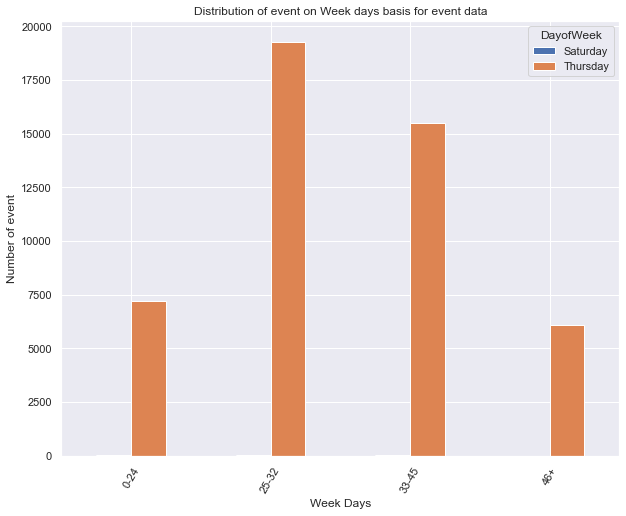

In [43]:
eventDataageBins_DOWdf.plot(kind='bar',figsize=(10,8),rot=60)
plt.title('Distribution of event on Week days basis for event data')
plt.xlabel('Week Days')
plt.ylabel('Number of event')

plt.show()

# 8. Stacked bar chart for the top 10 mobile brands across male and female consumers.

In [44]:
nonevents_df.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,3126957642374570000,M,27,M25-32,meitu,2
1,6005031767544890000,F,30,F25-32,meitu,2
2,-1463646610464190000,F,24,F0-24,meitu,2
3,4284600327477860000,F,22,F0-24,meitu,2
4,7858160688153530000,M,21,M0-24,meitu,2


In [45]:
top10branddf=nonevents_df.groupby(['phone_brand']).size().sort_values(ascending=False).head(10).reset_index()

In [46]:
top10branddf.head()

,phone_brand,0
0,Xiaomi,17337
1,samsung,13706
2,Huawei,13000
3,OPPO,5802
4,vivo,5658


In [47]:
top10brandwithgenderdf = nonevents_df.merge(top10branddf['phone_brand'],on='phone_brand').groupby('phone_brand').gender.value_counts().unstack()
top10brandwithgenderdf.head(10)

gender,F,M
phone_brand,,
Coolpad,1079,2270
Gionee,403,721
HTC,321,694
Huawei,4257,8743
Meizu,1306,3404
OPPO,2581,3221
Xiaomi,5930,11407
lenovo,894,1801
samsung,5443,8263


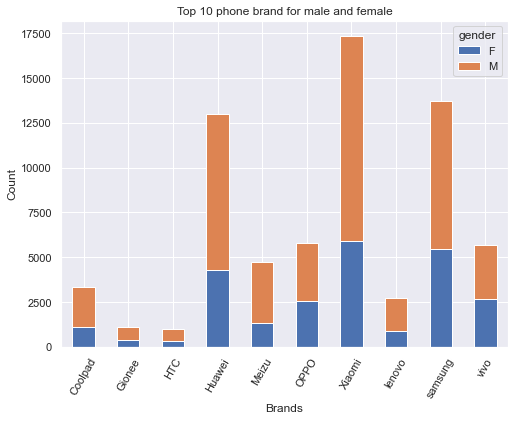

In [48]:
top10brandwithgenderdf.plot(kind='bar',stacked=True,figsize=(8,6),rot=60)
plt.title('Top 10 phone brand for male and female')
plt.xlabel('Brands')
plt.ylabel('Count')

plt.show()

# 9. Prepare a chart representing the ten frequently used applications and their respective male and female percentage.

In [49]:
event_apps = events_df.merge(app_df, on = 'event_id', how='inner')

In [50]:
event_apps.head()

,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek,app_id,is_installed,is_active,label_id,cat
0,-5344650000000000000,M,23,M0-24,1757983,2016-05-05 21:44:00,0,0.0,3,5,21,18,Thursday,-1.398440e+18,1,0,704,Property Industry 2.0
1,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,775,Liquid medium
2,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,752,fixed income
3,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,1015,mobile bank
4,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,704,Property Industry 2.0


In [51]:
most_apps = event_apps[['app_id']].groupby('app_id').agg({'app_id':['count']})

most_apps.columns = ['app_count']

print(most_apps.head())

most_apps_c = event_apps.groupby(['app_id']).gender.value_counts(1).unstack()

print(most_apps_c.head())

most_apps_c.columns = ['%count_F', '%count_M']

most = pd.merge(most_apps, most_apps_c, left_index=True, right_index=True, how='inner')

most.head()

               app_count
app_id                  
-1.633940e+18       4788
-1.633930e+18        192
-1.633910e+18      45669
-1.633890e+18         15
-1.633880e+18        264
gender                F         M
app_id                           
-1.633940e+18  0.137218  0.862782
-1.633930e+18  0.156250  0.843750
-1.633910e+18  0.395060  0.604940
-1.633890e+18       NaN  1.000000
-1.633880e+18  0.534091  0.465909


,app_count,%count_F,%count_M
app_id,,,
-1.633940e+18,4788,0.137218,0.862782
-1.633930e+18,192,0.156250,0.843750
-1.633910e+18,45669,0.395060,0.604940
-1.633890e+18,15,NaN,1.000000
-1.633880e+18,264,0.534091,0.465909


In [52]:
most = most.sort_values('app_count', ascending=False).head(10)
most

,app_count,%count_F,%count_M
app_id,,,
-1.633910e+18,45669,0.395060,0.604940
-1.051230e+18,11286,0.391281,0.608719
-1.405460e+18,7988,0.212819,0.787181
-1.017950e+18,4902,0.283354,0.716646
-1.398440e+18,4867,0.210807,0.789193
-1.633940e+18,4788,0.137218,0.862782
-1.633850e+18,2611,0.206817,0.793183
-1.633860e+18,2254,0.292813,0.707187
-1.442120e+18,2197,0.173873,0.826127


<AxesSubplot:xlabel='app_id'>

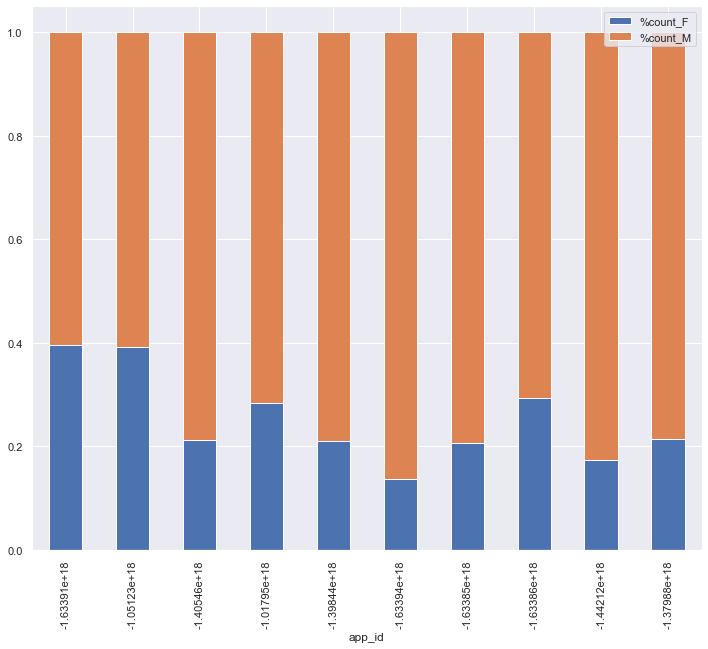

In [53]:
most[['%count_F', '%count_M']].plot(kind='bar', stacked=True, figsize=(12,10))

# 10. List the top 10 mobile phone brands bought by customers by age groups. [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

In [54]:
nonevents_df['Agebins']=pd.cut(nonevents_df['age'],bins=[0,24,32,45,100],labels=['0-24','25-32','33-45','46+'])
top10brandwithagebindf = nonevents_df.merge(top10branddf['phone_brand'],on='phone_brand').groupby('phone_brand').Agebins.value_counts().unstack()
top10brandwithagebindf.head()

Agebins,0-24,25-32,33-45,46+
phone_brand,,,,
Coolpad,811,1213,943,382
Gionee,328,400,279,117
HTC,237,436,251,91
Huawei,2449,5122,3975,1454
Meizu,1687,2057,690,276


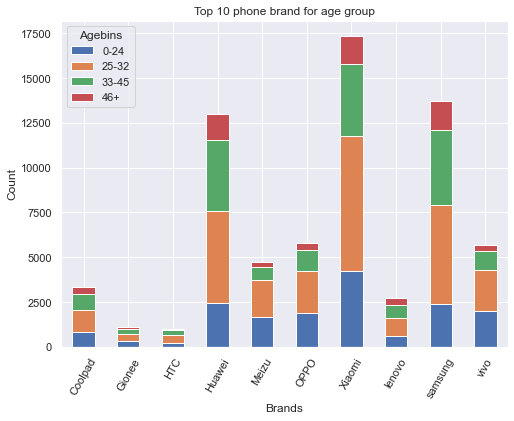

In [55]:
top10brandwithagebindf.plot(kind='bar',stacked=True,figsize=(8,6),rot=60)
plt.title('Top 10 phone brand for age group')
plt.xlabel('Brands')
plt.ylabel('Count')

plt.show()

# Advance Visualisation

# Plot the visualisation plot for a sample of 1 lakh data points.

In [56]:
sampleEventData= events_df.sample(n=100000).copy()
sampleEventData.shape

(100000, 13)

In [57]:
# we need to perform visulation on latitude, longitude, gender and age only so considering only those column
sampleEventData=sampleEventData[['longitude','latitude','age','gender']]
sampleEventData.head(5)

,longitude,latitude,age,gender
47766,118,28.95,43,F
90673,113,23.14,25,M
323874,106,29.61,34,M
262757,113,22.84,30,M
20782,1,1.00,33,F


In [58]:
# I have already installed these modules and imported above
#Need Matplotlib
#pip install basemap
#pip install basemap-data-hires
#pip install Pillow

# DBSCAN For Clustering


In [59]:
#Clean event DF(remove record with lat with 0 value or -ve)
cleaneventdf=events_df[~((events_df['latitude']>=-1) & (events_df['latitude']<=1) & (events_df['longitude']>=-1) & (events_df['longitude']<=1))]

print(cleaneventdf.shape)

cleaneventdf.head()

(222022, 13)


,device_id,gender,age,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek
0,2291390000000000000,M,46,M32+,1757890,2016-04-05 20:57:00,113,35.08,1,5,20,14,Tuesday
1,-6633250000000000000,M,48,M32+,1757907,2016-05-05 20:57:00,114,22.61,3,5,20,18,Thursday
2,-4989750000000000000,M,37,M32+,1757917,2016-05-05 21:45:00,114,30.56,3,5,21,18,Thursday
3,-4989750000000000000,M,37,M32+,1757918,2016-05-05 21:46:00,114,30.56,3,5,21,18,Thursday
4,-56875000000000000,M,39,M32+,1757935,2016-05-05 20:56:00,116,25.06,3,5,20,18,Thursday


In [60]:
cleanAggrigatedeventdf=cleaneventdf.groupby('device_id').agg({'DayofWeek':['nunique','count'],'longitude':'median','latitude':'median'},as_index=False).reset_index()

cleanAggrigatedeventdf.head()

device_id DayofWeek       longitude latitude
                         nunique count    median   median
0 -9222960000000000000         2     9     113.0   23.190
1 -9221030000000000000         5    36     114.0   30.870
2 -9220060000000000000         4    11     124.0   46.620
3 -9218770000000000000         1     2     112.0   28.575
4 -9215350000000000000         1     3     114.0   22.660

In [61]:
cleanAggrigatedeventdf.columns=['device_id','num_WeekDays','count_event','longitude','latitude']
cleanAggrigatedeventdf.head()

,device_id,num_WeekDays,count_event,longitude,latitude
0,-9222960000000000000,2,9,113.0,23.190
1,-9221030000000000000,5,36,114.0,30.870
2,-9220060000000000000,4,11,124.0,46.620
3,-9218770000000000000,1,2,112.0,28.575
4,-9215350000000000000,1,3,114.0,22.660


In [62]:
cleanAggrigatedeventdf.sort_values('count_event',ascending=False).head()

,device_id,num_WeekDays,count_event,longitude,latitude
1674,-6242500000000000000,3,1105,111.0,27.85
462,-8340100000000000000,5,1049,111.0,34.74
3080,-3746250000000000000,5,1009,123.0,41.82
8270,5375600000000000000,5,881,115.0,38.03
6195,1779630000000000000,5,757,114.0,30.57


In [63]:
cleanAggrigatedeventdf['avg_event']=cleanAggrigatedeventdf['count_event']/cleanAggrigatedeventdf['num_WeekDays']
cleanAggrigatedeventdf.head()

,device_id,num_WeekDays,count_event,longitude,latitude,avg_event
0,-9222960000000000000,2,9,113.0,23.190,4.50
1,-9221030000000000000,5,36,114.0,30.870,7.20
2,-9220060000000000000,4,11,124.0,46.620,2.75
3,-9218770000000000000,1,2,112.0,28.575,2.00
4,-9215350000000000000,1,3,114.0,22.660,3.00


In [64]:
cleanAggrigatedeventdf=cleanAggrigatedeventdf.astype({'longitude':'int','latitude':'int','avg_event':'int'})
cleanAggrigatedeventdf.head()

,device_id,num_WeekDays,count_event,longitude,latitude,avg_event
0,-9222960000000000000,2,9,113,23,4
1,-9221030000000000000,5,36,114,30,7
2,-9220060000000000000,4,11,124,46,2
3,-9218770000000000000,1,2,112,28,2
4,-9215350000000000000,1,3,114,22,3


In [65]:
cleanAggrigatedeventdf_withselectCol=cleanAggrigatedeventdf[['device_id','longitude','latitude','avg_event']]
cleanAggrigatedeventdf_withselectCol.head()

,device_id,longitude,latitude,avg_event
0,-9222960000000000000,113,23,4
1,-9221030000000000000,114,30,7
2,-9220060000000000000,124,46,2
3,-9218770000000000000,112,28,2
4,-9215350000000000000,114,22,3


In [66]:
from sklearn.cluster import DBSCAN

coords=cleanAggrigatedeventdf_withselectCol[['longitude','latitude']].values
kms_per_radian = 6371.0088
epsilon = 90/kms_per_radian
db = DBSCAN(eps= epsilon, min_samples= 30, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

cleanAggrigatedeventdf_withselectCol['clusterId']=db.labels_

cleanAggrigatedeventdf_withselectCol.sort_values('clusterId',ascending=False).head()

<ipython-input-66-92783f5cd938>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanAggrigatedeventdf_withselectCol['clusterId']=db.labels_


,device_id,longitude,latitude,avg_event,clusterId
489,-8300300000000000000,116,29,2,36
2665,-4508280000000000000,116,28,1,36
1743,-6127460000000000000,116,29,1,36
9166,6972260000000000000,116,28,3,36
8984,6686000000000000000,116,29,2,36


In [67]:
cleanAggrigatedeventdf_withselectCol.shape

(10366, 5)

In [68]:
eventdf_withAgg = cleanAggrigatedeventdf_withselectCol.merge(cleaneventdf, on='device_id',how='inner')
eventdf_withAgg = eventdf_withAgg[['device_id','longitude_y','latitude_y','avg_event','clusterId','gender','age','event_id','dayofweek_num','day','hour','week']]
eventdf_withAgg.head()

,device_id,longitude_y,latitude_y,avg_event,clusterId,gender,age,event_id,dayofweek_num,day,hour,week
0,-9222960000000000000,113,23.19,4,0,M,36,1794538,1,5,7,27
1,-9222960000000000000,113,23.19,4,0,M,36,2068832,1,5,12,27
2,-9222960000000000000,113,23.19,4,0,M,36,2085015,6,5,15,22
3,-9222960000000000000,113,23.19,4,0,M,36,2085017,6,5,15,22
4,-9222960000000000000,113,23.19,4,0,M,36,2111353,1,5,12,27


In [69]:
appDatadf1=pd.read_csv('app_data_1M.csv',header=0,names=['event_id','app_id','is_installed','is_active','label_id','category'],quoting=csv.QUOTE_NONE)
appDatadf1.head()

NameError: name 'csv' is not defined

In [ ]:
appDatadf= appDatadf1.sample(n=1000000).copy()
appDatadf.head()

In [70]:
#Dropping is)installed & app_id columns
appDatadf.drop(['is_installed','app_id'],axis=1,inplace=True)

NameError: name 'appDatadf' is not defined

In [71]:
appDatadf.head()

NameError: name 'appDatadf' is not defined

In [72]:
eventdf_withAgg = eventdf_withAgg.merge(appDatadf, on='event_id',how='inner')

NameError: name 'appDatadf' is not defined

In [73]:
eventdf_withAgg.head()

,device_id,longitude_y,latitude_y,avg_event,clusterId,gender,age,event_id,dayofweek_num,day,hour,week
0,-9222960000000000000,113,23.19,4,0,M,36,1794538,1,5,7,27
1,-9222960000000000000,113,23.19,4,0,M,36,2068832,1,5,12,27
2,-9222960000000000000,113,23.19,4,0,M,36,2085015,6,5,15,22
3,-9222960000000000000,113,23.19,4,0,M,36,2085017,6,5,15,22
4,-9222960000000000000,113,23.19,4,0,M,36,2111353,1,5,12,27


In [74]:
eventdf_withAgg.shape

(222022, 12)

In [75]:
labels = cleanAggrigatedeventdf_withselectCol['clusterId'].tolist()

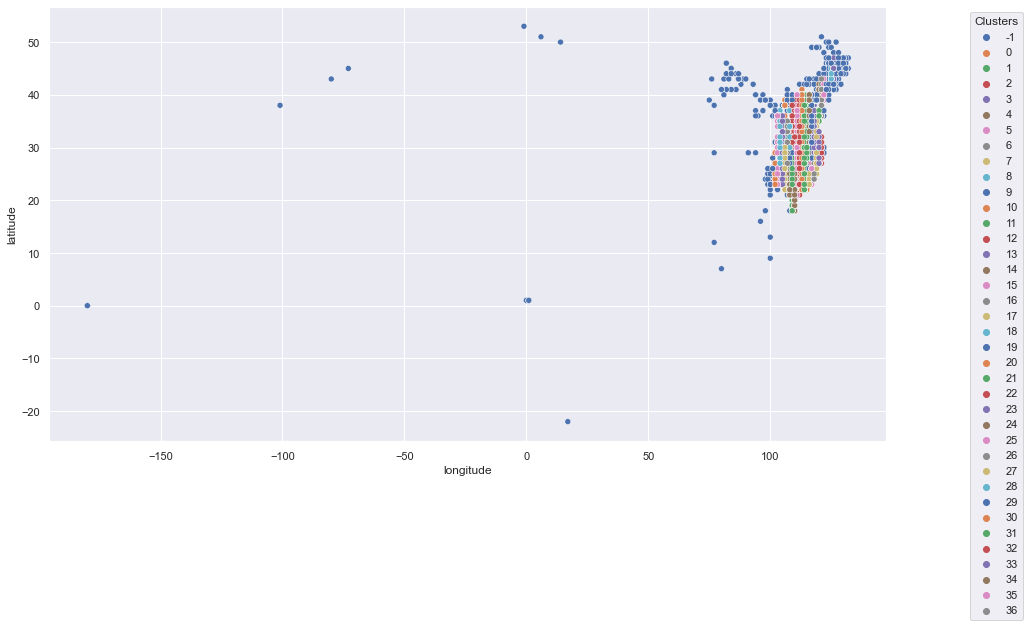

In [76]:
plt.figure(figsize=(15,8))
p = sns.scatterplot(data= cleanAggrigatedeventdf_withselectCol, x="longitude", y="latitude", hue= labels, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1), title='Clusters')
plt.show()

In [77]:
#Importing the Libaries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#labelling the categorical data 
lab_ = LabelEncoder()
enc_lab = lab_.fit_transform( nonevents_df["phone_brand"])

lab_ = LabelEncoder()
enc_lab = lab_.fit_transform( nonevents_df["group_train"])

lab_ = LabelEncoder()
enc_lab = lab_.fit_transform( nonevents_df["gender"])

lab_ = LabelEncoder()
enc_lab = lab_.fit_transform( events_df["group_train"])

lab_ = LabelEncoder()
enc_lab = lab_.fit_transform( events_df["group_train"])

lab_ = LabelEncoder()
enc_lab = lab_.fit_transform(app_df["cat"])

#Encoding the Categorical data
enc_ = OneHotEncoder()
enc_ohe = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

enc_ = OneHotEncoder()
enc_ohe1 = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

enc_ = OneHotEncoder()
enc_ohe2 = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

enc_ = OneHotEncoder()
enc_ohe3 = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

enc_ = OneHotEncoder()
enc_ohe4 = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

enc_ = OneHotEncoder()
enc_ohe5 = enc_.fit_transform(enc_lab.reshape(-1,1)).toarray()

h_stack1 = np.hstack((enc_ohe,enc_ohe1,enc_ohe2))
h_stack2 = np.hstack((enc_ohe3,enc_ohe4))

print(h_stack1)
print(h_stack2)
print(enc_ohe5)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### MakingTrainTestSplit

In [78]:
testtrain_df = pd.read_csv("traintest.csv")

In [79]:
testtrain_df.head()

,device_id,gender,age,group,train_test_flag
0,-7548291590301750000,M,33,M32+,train
1,6943568600617760000,M,37,M32+,train
2,5441349705980020000,M,40,M32+,train
3,-5393876656119450000,M,33,M32+,train
4,4543988487649880000,M,53,M32+,train


In [110]:
#Creating the dataset for Scenario 1 ( Which is all the feature in dataset)
scenario_1a = scenario_1.join(testtrain_df , lsuffix="_x" , how = "inner")

In [111]:
scenario_1a.head()

,device_id_x,gender_x,age_x,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,...,app_id,is_installed,is_active,label_id,cat,device_id,gender,age,group,train_test_flag
0,-5344650000000000000,M,23,M0-24,1757983,2016-05-05 21:44:00,0,0.0,3,5,...,-1.398440e+18,1,0,704,Property Industry 2.0,-7548291590301750000,M,33,M32+,train
1,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,...,-1.405460e+18,1,0,775,Liquid medium,6943568600617760000,M,37,M32+,train
2,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,...,-1.405460e+18,1,0,752,fixed income,5441349705980020000,M,40,M32+,train
3,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,...,-1.405460e+18,1,0,1015,mobile bank,-5393876656119450000,M,33,M32+,train
4,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,...,-1.405460e+18,1,0,704,Property Industry 2.0,4543988487649880000,M,53,M32+,train


In [106]:
scenario_1a = scenario_1a .drop(["device_id","gender","age","group"], axis=1)

In [107]:
scenario_1a.head()

,device_id_x,gender_x,age_x,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek,app_id,is_installed,is_active,label_id,cat,train_test_flag
0,-5344650000000000000,M,23,M0-24,1757983,2016-05-05 21:44:00,0,0.0,3,5,21,18,Thursday,-1.398440e+18,1,0,704,Property Industry 2.0,train
1,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,775,Liquid medium,train
2,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,752,fixed income,train
3,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,1015,mobile bank,train
4,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,704,Property Industry 2.0,train


In [85]:
#Creating the dataset for Scenario 2( which is Just Phone_brand and etc)
scenario_2 = pd.merge(nonevents_df,testtrain_df)

In [86]:
scenario_2.head()

,device_id,gender,age,group_train,phone_brand,device_model,Agebins,group,train_test_flag
0,3126957642374570000,M,27,M25-32,meitu,2,25-32,M25-32,train
1,6005031767544890000,F,30,F25-32,meitu,2,25-32,F25-32,train
2,-1463646610464190000,F,24,F0-24,meitu,2,0-24,F0-24,train
3,4284600327477860000,F,22,F0-24,meitu,2,0-24,F0-24,train
4,7858160688153530000,M,21,M0-24,meitu,2,0-24,M0-24,train


In [88]:
#Creating the Train dataset for scenario 1
train_s1 = scenario_1a[scenario_1a["train_test_flag"] == "train"]
test_s1 = scenario_1a[scenario_1a["train_test_flag"] == "test"]

In [89]:
#creating the Test dataset for scenario 2
train_s2 = scenario_2[scenario_2["train_test_flag"] == "train"]
test_s2 = scenario_2[scenario_2["train_test_flag"] == "test"]

In [90]:
train_s1.head()

,device_id_x,gender_x,age_x,group_train,event_id,eventdate,longitude,latitude,dayofweek_num,day,hour,week,DayofWeek,app_id,is_installed,is_active,label_id,cat,train_test_flag
0,-5344650000000000000,M,23,M0-24,1757983,2016-05-05 21:44:00,0,0.0,3,5,21,18,Thursday,-1.398440e+18,1,0,704,Property Industry 2.0,train
1,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,775,Liquid medium,train
2,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,752,fixed income,train
3,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,1015,mobile bank,train
4,-2458720000000000000,F,34,F32+,1758040,2016-05-05 21:15:00,0,0.0,3,5,21,18,Thursday,-1.405460e+18,1,0,704,Property Industry 2.0,train


In [92]:
X_train_s1 = train_s1.drop(["age_x"], axis = 1)
Y_train_s1 = train_s1["age_x"]

In [97]:
X_test_s1 = test_s1.drop(["age_x" ],axis = 1)
y_test_s1 = test_s1["age_x"]